### Load the necessary packages

In [1]:
from IPython.core.interactiveshell import InteractiveShell
import seaborn as sns
# PyTorch
from torchvision import transforms, datasets, models
import torch
from torch import optim, cuda
from torch.utils.data import DataLoader, sampler
import torch.nn as nn

from torch_lr_finder import LRFinder

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Data science tools
import numpy as np
import pandas as pd
import os

# Image manipulations
from PIL import Image
# Useful for examining network
from torchsummary import summary
# Timing utility
from timeit import default_timer as timer

# Visualizations
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.size'] = 14

# Printing out all outputs
InteractiveShell.ast_node_interactivity = 'all'

C:\ProgramData\Anaconda3\lib\site-packages\tqdm\autonotebook\__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)
  pip install torch-lr-finder -v --global-option="amp"


### Initalize parameters

In [20]:
# Location of data
datadir = '../data/'
traindir = datadir + 'train/'
validdir = datadir + 'valid/'
testdir = datadir + 'test/'

save_file_name = 'vgg16-transfer6.pt'
checkpoint_file_name = 'vgg16-transfer6.pth'

# Change to fit hardware
batch_size = 64

image_size = 224

# Whether to train on a gpu
train_on_gpu = cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')

# Number of gpus
if train_on_gpu:
    gpu_count = cuda.device_count()
    print(f'{gpu_count} gpus detected.')
    if gpu_count > 1:
        multi_gpu = True
    else:
        multi_gpu = False

Train on gpu: True
1 gpus detected.


### Image Augmentation

In [3]:
image_transforms = {
    # Train uses data augmentation
    'train':
    transforms.Compose([
        transforms.RandomResizedCrop(size=image_size),
        transforms.RandomRotation(degrees=45),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomAffine(45),
        transforms.ColorJitter(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])  # Imagenet standards
    ]),
    # Validation does not use augmentation
    'val':
    transforms.Compose([
        transforms.RandomResizedCrop(size=image_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    # Test does not use augmentation
    'test':
    transforms.Compose([
        transforms.RandomCrop(size=image_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

### Data Iterators

In [4]:
# Datasets from each folder
data = {
    'train':
    datasets.ImageFolder(root=traindir, transform=image_transforms['train']),
    'val':
    datasets.ImageFolder(root=validdir, transform=image_transforms['val'])
#     'test':
#     datasets.ImageFolder(root=testdir, transform=image_transforms['test'])
}

# Dataloader iterators
dataloaders = {
    'train': DataLoader(data['train'], batch_size=batch_size, shuffle=True),
    'val': DataLoader(data['val'], batch_size=batch_size, shuffle=True)
#     'test': DataLoader(data['test'], batch_size=batch_size, shuffle=True)
}

### Model Setup
#### Load Pre-trained VGG16 Model

In [5]:
model = models.resnet50(pretrained=True)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

#### Freeze weights of early layers of the VGG16 Model

In [6]:
for param in model.parameters():
    param.requires_grad = False

#### Replace Last layer with fully connected layer configured for the task at hand

In [7]:
n_classes = 101

n_inputs = model.fc.in_features
# Add on classifier
# classifier = nn.Sequential(
#     nn.Linear(n_inputs, 224), 
#     nn.ReLU(inplace=True),
#     nn.Dropout(0.5),
#     nn.Linear(224,224),
#     nn.ReLU(inplace=True),
#     nn.Dropout(0.5),
#     nn.Linear(224, n_classes), 
#     nn.LogSoftmax(dim=1))

# 45% max set at model.classifier[6]
# classifier = nn.Sequential(
#     nn.Flatten(),
#     nn.Linear(n_inputs,224),
#     nn.LeakyReLU(),
#     nn.Dropout(0.4),
#     nn.Linear(224,n_classes),
#     nn.LogSoftmax(dim=1))

classifier = nn.Sequential(
    nn.Linear(n_inputs,image_size),
    nn.LeakyReLU(),
    nn.Linear(image_size,n_classes),
    nn.LogSoftmax(dim=1)
)

model.fc = classifier
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

#### Move model to GPU

In [8]:
if train_on_gpu:
    model = model.to('cuda')

if multi_gpu:
    model = nn.DataParallel(model)

#### Mapping of food labels to indexes

In [9]:
model.class_to_idx = data['train'].class_to_idx
model.idx_to_class = {
    idx: class_
    for class_, idx in model.class_to_idx.items()
}

list(model.idx_to_class.items())[:10]

[(0, 'apple_pie'),
 (1, 'baby_back_ribs'),
 (2, 'baklava'),
 (3, 'beef_carpaccio'),
 (4, 'beef_tartare'),
 (5, 'beet_salad'),
 (6, 'beignets'),
 (7, 'bibimbap'),
 (8, 'bread_pudding'),
 (9, 'breakfast_burrito')]

### Finding the Right Learning Rate

In [10]:
# # we will be using negative log likelihood as the loss function
# criterion = nn.CrossEntropyLoss()
# # we will be using the SGD optimizer as our optimizer
# optimizer = optim.SGD(model.parameters(), lr=1e-5)
# lr_finder = LRFinder(model, optimizer, criterion, device='cuda')
# lr_finder.range_test(dataloaders['train'], end_lr=1, num_iter=2000)
# lr_finder.plot()
# lr_finder.reset()

### Training Loss and Optimizer

In [11]:
# we will be using negative log likelihood as the loss function
criterion = nn.CrossEntropyLoss()
# we will be using the Adam optimizer as our optimizer
optimizer = optim.SGD(model.fc.parameters(), lr=0.01, momentum=0.9)

# secify learning rate scheduler (if there is no further decrease in loss for next 5 epochs 
# then lower the learning rate by 0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience = 5)


In [26]:
def train_model(model,
               criterion,
               optimizer,
               scheduler,
               train_loader,
               valid_loader,
               save_file_name,
               checkpoint_file_name,
               max_epochs_stop=3,
               n_epochs=25,
               print_every=2
               ):
    """Train a PyTorch Model

    Params
    --------
        model (PyTorch model): cnn to train
        criterion (PyTorch loss): objective to minimize
        optimizer (PyTorch optimizier): optimizer to compute gradients of model parameters
        train_loader (PyTorch dataloader): training dataloader to iterate through
        valid_loader (PyTorch dataloader): validation dataloader used for early stopping
        save_file_name (str ending in '.pt'): file path to save the model state dict
        max_epochs_stop (int): maximum number of epochs with no improvement in validation loss for early stopping
        n_epochs (int): maximum number of training epochs
        print_every (int): frequency of epochs to print training stats

    Returns
    --------
        model (PyTorch model): trained cnn with best weights
        history (DataFrame): history of train and validation loss and accuracy
    """
    # early stopping initializaiton
    epochs_no_improve = 0
    valid_loss_min = np.Inf
    
    valid_max_acc = 0
    history = []
    
    # number of epochs already trained (if using loaded in model weights)
    try:
        print("Model has been trained for: {} epochs.\n".format(model.epochs))
    except:
        model.epochs = 0
        print("Starting training from scratch.\n")
        
    overall_start = timer()
    
    #Main loop
    for epoch in range(n_epochs):
        
        #keep track of training and validation loss of each epoch
        train_loss = 0.0
        valid_loss = 0.0
        
        train_acc = 0
        valid_acc = 0
        
        #set to training
        model.train()
        start = timer()
        
        # training loop
        for ii, (data, target) in enumerate(train_loader):
            #tensors to gpu
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()
                
            # clear gradients
            optimizer.zero_grad()
            #predicted outpouts are log probabilities
            output = model(data)
            
            # loss and backpropagation of gradients
            loss = criterion(output, target)
            loss.backward()
            
            # update the parameters
            optimizer.step()
            
            # track train loss by multiplying average loss by number of examples in batch
            train_loss += loss.item() * data.size(0)
            
            # calculate accuracy by finding max log probability
            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(target.data.view_as(pred))
            # need to convert correct tensor from int to float to average
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            # multiply average accuracy times the number of examples in batch
            train_acc += accuracy.item() * data.size(0)
            
            # Track training progress
            print(
                f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.',
                end='\r')
        # after training loop ends
        else:
            model.epochs += 1
            
            # don't need to keep track of gradients
            with torch.no_grad():
                # set to evaluation mode
                model.eval()
                
                #validation loop
                for data, target in valid_loader:
                    #tensors to gpu
                    if train_on_gpu:
                        data, target = data.cuda(), target.cuda()
                        
                    # Forward pass
                    output = model(data)
                    
                    # validation loss 
                    loss = criterion(output, target)
                    # multiply average loss times the number of examples in batch
                    valid_loss += loss.item() * data.size(0)
                    
                    # calculate validation accuracy
                    _, pred = torch.max(output, dim=1)
                    correct_tensor = pred.eq(target.data.view_as(pred))
                    accuracy = torch.mean(
                        correct_tensor.type(torch.FloatTensor))
                    # multiply average accuracy times the number of examples
                    valid_acc += accuracy.item() * data.size(0)
                    
                # calculate average losses
                train_loss = train_loss / (len(train_loader.dataset))
                valid_loss = valid_loss / (len(valid_loader.dataset))
                
                # calculate average accuracy
                train_acc = train_acc / (len(train_loader.dataset))
                valid_acc = valid_acc / (len(valid_loader.dataset))
                
                # learning rate scheduler step
                scheduler.step(valid_loss)
                
                history.append([train_loss, valid_loss, train_acc, valid_acc])
                
                # Print training and validation results
                if (epoch + 1) % print_every == 0:
                    print(
                        f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}'
                    )
                    print(
                        f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%'
                    )
                    
                # save the model if validation loss decreases
                if valid_loss < valid_loss_min:
                    print("Valid loss decreased ({:.6f} --> {:.6f}). Saving model...".format(valid_loss_min, valid_loss))
                    
                    # save model
                    torch.save(model.state_dict(), save_file_name)
                    
                    checkpoint = {
                        "model": model,
                        "criterion": criterion,
                        "epochs": model.epochs,
                        "optimizer_state": optimizer.state_dict(),
                        "model_state": model.state_dict(),
                        "valid_loss_min": valid_loss
                    }
                    torch.save(checkpoint, checkpoint_file_name)
                    
                    # track improvements
                    epochs_no_improve = 0
                    valid_loss_min = valid_loss
                    valid_best_acc = valid_acc
                    best_epoch = epoch
                    
                # otherwise increment count of epochs with no improvement
                else:
                    epochs_no_improve += 1
                    #trigger early stopping
                    if epochs_no_improve >= max_epochs_stop:
                        print(
                            f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
                        )
                        total_time = timer() - overall_start
                        print(
                            f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
                        )
                        
                        # load the best state dict
                        model.load_state_dict(torch.load(save_file_name))
                        # attach the optimizer
                        model.optimizer = optimizer
                        
                        # format history
                        history = pd.DataFrame(
                                history,
                                columns=[
                                    'train_loss', 'valid_loss', 'train_acc',
                                    'valid_acc'
                                ])
                        return model, history
                    
    model.optimizer = optimizer
    total_time = timer() - overall_start
    print(
        f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
    )
    print(
        f'{total_time:.2f} total seconds elapsed. {total_time / (model.epochs):.2f} seconds per epoch.'
    )
    # Format history
    history = pd.DataFrame(
        history,
        columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])
    return model, history

In [13]:
model, history = train_model(
    model,
    criterion,
    optimizer,
    scheduler,
    dataloaders['train'],
    dataloaders['val'],
    save_file_name=save_file_name,
    checkpoint_file_name=checkpoint_file_name,
    max_epochs_stop=10,
    n_epochs=20,
    print_every=1
    )

Starting training from scratch.

Epoch: 0	100.00% complete. 730.81 seconds elapsed in epoch.
Epoch: 0 	Training Loss: 3.2175 	Validation Loss: 2.4946
		Training Accuracy: 25.22%	 Validation Accuracy: 37.97%
Epoch: 1	100.00% complete. 708.34 seconds elapsed in epoch.
Epoch: 1 	Training Loss: 2.7032 	Validation Loss: 2.4486
		Training Accuracy: 35.26%	 Validation Accuracy: 38.89%
Epoch: 2	100.00% complete. 712.41 seconds elapsed in epoch.
Epoch: 2 	Training Loss: 2.6213 	Validation Loss: 2.2623
		Training Accuracy: 36.92%	 Validation Accuracy: 43.47%
Epoch: 3	100.00% complete. 717.82 seconds elapsed in epoch.
Epoch: 3 	Training Loss: 2.5681 	Validation Loss: 2.3765
		Training Accuracy: 38.11%	 Validation Accuracy: 41.18%
Epoch: 4	100.00% complete. 707.18 seconds elapsed in epoch.
Epoch: 4 	Training Loss: 2.5398 	Validation Loss: 2.2116
		Training Accuracy: 38.73%	 Validation Accuracy: 44.19%
Epoch: 5	100.00% complete. 709.65 seconds elapsed in epoch.
Epoch: 5 	Training Loss: 2.5071 	Vali

Text(0.5, 1.0, 'model accuracy')

Text(0, 0.5, 'accuracy')

Text(0.5, 0, 'epoch')

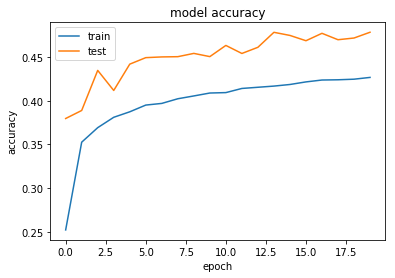

Text(0.5, 1.0, 'model loss')

Text(0, 0.5, 'loss')

Text(0.5, 0, 'epoch')

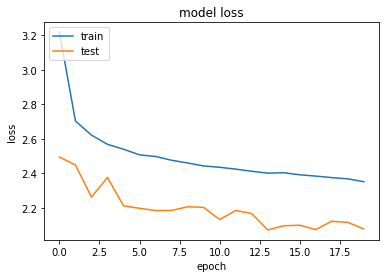

In [14]:

# summarize history for accuracy
plt.plot(history['train_acc'])
plt.plot(history['valid_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history['train_loss'])
plt.plot(history['valid_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [15]:
# unfreeze all layers of network
for param in model.parameters():
    param.required_grad = False
    
# we will be using negative log likelihood as the loss function
criterion = nn.CrossEntropyLoss()
# we will be using the SGD optimizer as our optimizer, update parameters to include entire network
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# secify learning rate scheduler (if there is no further decrease in loss for next 5 epochs 
# then lower the learning rate by 0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience = 5)


In [16]:
model, history = train_model(
    model,
    criterion,
    optimizer,
    scheduler,
    dataloaders['train'],
    dataloaders['val'],
    save_file_name=save_file_name,
    checkpoint_file_name=checkpoint_file_name,
    max_epochs_stop=10,
    n_epochs=150,
    print_every=1
    )

Model has been trained for: 20 epochs.

Epoch: 0	100.00% complete. 710.69 seconds elapsed in epoch.
Epoch: 0 	Training Loss: 2.3517 	Validation Loss: 2.0705
		Training Accuracy: 42.86%	 Validation Accuracy: 47.96%
Epoch: 1	100.00% complete. 711.35 seconds elapsed in epoch.
Epoch: 1 	Training Loss: 2.3446 	Validation Loss: 2.0143
		Training Accuracy: 42.86%	 Validation Accuracy: 49.35%
Epoch: 2	100.00% complete. 710.92 seconds elapsed in epoch.
Epoch: 2 	Training Loss: 2.3430 	Validation Loss: 1.9931
		Training Accuracy: 43.31%	 Validation Accuracy: 49.69%
Epoch: 3	100.00% complete. 710.98 seconds elapsed in epoch.
Epoch: 3 	Training Loss: 2.3430 	Validation Loss: 2.0065
		Training Accuracy: 43.24%	 Validation Accuracy: 49.24%
Epoch: 4	100.00% complete. 711.91 seconds elapsed in epoch.
Epoch: 4 	Training Loss: 2.3380 	Validation Loss: 2.0279
		Training Accuracy: 43.12%	 Validation Accuracy: 48.70%
Epoch: 5	100.00% complete. 712.26 seconds elapsed in epoch.
Epoch: 5 	Training Loss: 2.325

Text(0.5, 1.0, 'model accuracy')

Text(0, 0.5, 'accuracy')

Text(0.5, 0, 'epoch')

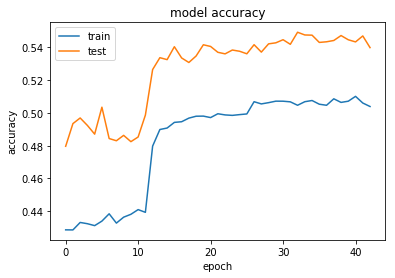

Text(0.5, 1.0, 'model loss')

Text(0, 0.5, 'loss')

Text(0.5, 0, 'epoch')

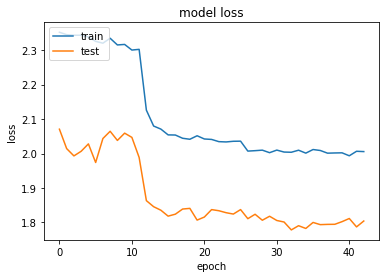

In [17]:
# summarize history for accuracy
plt.plot(history['train_acc'])
plt.plot(history['valid_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history['train_loss'])
plt.plot(history['valid_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [28]:
# unfreeze all layers of network
for param in model.parameters():
    param.required_grad = False
    
# we will be using negative log likelihood as the loss function
criterion = nn.CrossEntropyLoss()
# we will be using the SGD optimizer as our optimizer, update parameters to include entire network
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# secify learning rate scheduler (if there is no further decrease in loss for next 5 epochs 
# then lower the learning rate by 0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience = 5)


In [ ]:
model, history = train_model(
    model,
    criterion,
    optimizer,
    scheduler,
    dataloaders['train'],
    dataloaders['val'],
    save_file_name=save_file_name,
    checkpoint_file_name=checkpoint_file_name,
    max_epochs_stop=15,
    n_epochs=150,
    print_every=1
    )

Model has been trained for: 66 epochs.

Epoch: 0	100.00% complete. 755.41 seconds elapsed in epoch.
Epoch: 0 	Training Loss: 2.2965 	Validation Loss: 2.0333
		Training Accuracy: 44.34%	 Validation Accuracy: 49.35%
Valid loss decreased (inf --> 2.033298). Saving model...


C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ResNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type BatchNorm2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ReLU. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\ProgramDat

Epoch: 1	100.00% complete. 752.49 seconds elapsed in epoch.
Epoch: 1 	Training Loss: 2.2933 	Validation Loss: 2.0427
		Training Accuracy: 44.19%	 Validation Accuracy: 49.05%
Epoch: 2	100.00% complete. 752.24 seconds elapsed in epoch.
Epoch: 2 	Training Loss: 2.2910 	Validation Loss: 2.0033
		Training Accuracy: 44.21%	 Validation Accuracy: 49.47%
Valid loss decreased (2.033298 --> 2.003335). Saving model...


C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ResNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type BatchNorm2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ReLU. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\ProgramDat

Epoch: 3	100.00% complete. 751.18 seconds elapsed in epoch.
Epoch: 3 	Training Loss: 2.2881 	Validation Loss: 2.0303
		Training Accuracy: 44.31%	 Validation Accuracy: 48.89%
Epoch: 4	100.00% complete. 734.95 seconds elapsed in epoch.
Epoch: 4 	Training Loss: 2.2825 	Validation Loss: 1.9804
		Training Accuracy: 44.35%	 Validation Accuracy: 50.34%
Valid loss decreased (2.003335 --> 1.980425). Saving model...


C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ResNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type BatchNorm2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ReLU. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\ProgramDat

Epoch: 5	100.00% complete. 737.78 seconds elapsed in epoch.
Epoch: 5 	Training Loss: 2.2924 	Validation Loss: 2.0480
		Training Accuracy: 44.22%	 Validation Accuracy: 48.81%
Epoch: 6	100.00% complete. 738.80 seconds elapsed in epoch.
Epoch: 6 	Training Loss: 2.2755 	Validation Loss: 2.0790
		Training Accuracy: 44.43%	 Validation Accuracy: 47.81%
Epoch: 7	100.00% complete. 739.30 seconds elapsed in epoch.
Epoch: 7 	Training Loss: 2.2780 	Validation Loss: 2.0635
		Training Accuracy: 44.47%	 Validation Accuracy: 48.65%
Epoch: 8	100.00% complete. 738.36 seconds elapsed in epoch.
Epoch: 8 	Training Loss: 2.2791 	Validation Loss: 1.9994
		Training Accuracy: 44.45%	 Validation Accuracy: 49.43%
Epoch: 9	100.00% complete. 737.38 seconds elapsed in epoch.
Epoch: 9 	Training Loss: 2.2809 	Validation Loss: 2.0141
		Training Accuracy: 44.47%	 Validation Accuracy: 50.07%
Epoch: 10	100.00% complete. 736.09 seconds elapsed in epoch.
Epoch: 10 	Training Loss: 2.2652 	Validation Loss: 2.0380
		Training 

C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ResNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type BatchNorm2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ReLU. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\ProgramDat

Epoch: 12	100.00% complete. 736.85 seconds elapsed in epoch.
Epoch: 12 	Training Loss: 2.0436 	Validation Loss: 1.8342
		Training Accuracy: 49.68%	 Validation Accuracy: 53.52%
Epoch: 13	100.00% complete. 734.26 seconds elapsed in epoch.
Epoch: 13 	Training Loss: 2.0318 	Validation Loss: 1.8019
		Training Accuracy: 50.22%	 Validation Accuracy: 54.56%
Valid loss decreased (1.810666 --> 1.801892). Saving model...


C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ResNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type BatchNorm2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ReLU. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\ProgramDat

Epoch: 14	100.00% complete. 735.01 seconds elapsed in epoch.
Epoch: 14 	Training Loss: 2.0226 	Validation Loss: 1.7935
		Training Accuracy: 50.16%	 Validation Accuracy: 54.76%
Valid loss decreased (1.801892 --> 1.793496). Saving model...


C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ResNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type BatchNorm2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ReLU. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\ProgramDat

Epoch: 15	100.00% complete. 734.92 seconds elapsed in epoch.
Epoch: 15 	Training Loss: 2.0155 	Validation Loss: 1.8129
		Training Accuracy: 50.27%	 Validation Accuracy: 53.81%
Epoch: 16	100.00% complete. 734.16 seconds elapsed in epoch.
Epoch: 16 	Training Loss: 2.0128 	Validation Loss: 1.8105
		Training Accuracy: 50.50%	 Validation Accuracy: 54.08%
Epoch: 17	100.00% complete. 734.29 seconds elapsed in epoch.
Epoch: 17 	Training Loss: 2.0155 	Validation Loss: 1.7996
		Training Accuracy: 50.36%	 Validation Accuracy: 54.12%
Epoch: 18	100.00% complete. 734.67 seconds elapsed in epoch.
Epoch: 18 	Training Loss: 1.9975 	Validation Loss: 1.8171
		Training Accuracy: 50.64%	 Validation Accuracy: 54.02%
Epoch: 19	100.00% complete. 745.99 seconds elapsed in epoch.
Epoch: 19 	Training Loss: 2.0062 	Validation Loss: 1.7930
		Training Accuracy: 50.52%	 Validation Accuracy: 54.73%
Valid loss decreased (1.793496 --> 1.793043). Saving model...


C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ResNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type BatchNorm2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ReLU. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\ProgramDat

Epoch: 20	100.00% complete. 739.72 seconds elapsed in epoch.
Epoch: 20 	Training Loss: 2.0028 	Validation Loss: 1.7675
		Training Accuracy: 50.55%	 Validation Accuracy: 55.13%
Valid loss decreased (1.793043 --> 1.767523). Saving model...


C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ResNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type BatchNorm2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ReLU. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\ProgramDat

Epoch: 21	100.00% complete. 740.19 seconds elapsed in epoch.
Epoch: 21 	Training Loss: 2.0026 	Validation Loss: 1.7686
		Training Accuracy: 50.74%	 Validation Accuracy: 54.87%
Epoch: 22	100.00% complete. 740.01 seconds elapsed in epoch.
Epoch: 22 	Training Loss: 1.9991 	Validation Loss: 1.7918
		Training Accuracy: 50.81%	 Validation Accuracy: 54.39%
Epoch: 23	100.00% complete. 739.71 seconds elapsed in epoch.
Epoch: 23 	Training Loss: 2.0010 	Validation Loss: 1.7861
		Training Accuracy: 50.65%	 Validation Accuracy: 54.89%
Epoch: 24	100.00% complete. 739.58 seconds elapsed in epoch.
Epoch: 24 	Training Loss: 1.9953 	Validation Loss: 1.7906
		Training Accuracy: 50.88%	 Validation Accuracy: 54.85%
Epoch: 25	100.00% complete. 740.67 seconds elapsed in epoch.
Epoch: 25 	Training Loss: 1.9947 	Validation Loss: 1.7961
		Training Accuracy: 51.01%	 Validation Accuracy: 54.28%
Epoch: 26	100.00% complete. 739.97 seconds elapsed in epoch.
Epoch: 26 	Training Loss: 1.9949 	Validation Loss: 1.7821
	

C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ResNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type BatchNorm2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ReLU. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\ProgramDat

Epoch: 28	100.00% complete. 741.31 seconds elapsed in epoch.
Epoch: 28 	Training Loss: 1.9731 	Validation Loss: 1.7588
		Training Accuracy: 51.28%	 Validation Accuracy: 55.39%
Valid loss decreased (1.767327 --> 1.758840). Saving model...


C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ResNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type BatchNorm2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ReLU. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\ProgramDat

Epoch: 29	100.00% complete. 741.17 seconds elapsed in epoch.
Epoch: 29 	Training Loss: 1.9679 	Validation Loss: 1.7888
		Training Accuracy: 51.56%	 Validation Accuracy: 54.61%
Epoch: 30	100.00% complete. 740.73 seconds elapsed in epoch.
Epoch: 30 	Training Loss: 1.9702 	Validation Loss: 1.7837
		Training Accuracy: 51.30%	 Validation Accuracy: 54.80%
Epoch: 31	100.00% complete. 743.55 seconds elapsed in epoch.
Epoch: 31 	Training Loss: 1.9639 	Validation Loss: 1.7646
		Training Accuracy: 51.60%	 Validation Accuracy: 55.01%
Epoch: 32	100.00% complete. 742.24 seconds elapsed in epoch.
Epoch: 32 	Training Loss: 1.9715 	Validation Loss: 1.7626
		Training Accuracy: 51.50%	 Validation Accuracy: 55.28%
Epoch: 33	100.00% complete. 744.02 seconds elapsed in epoch.
Epoch: 33 	Training Loss: 1.9711 	Validation Loss: 1.7600
		Training Accuracy: 51.40%	 Validation Accuracy: 55.14%
Epoch: 34	100.00% complete. 743.00 seconds elapsed in epoch.
Epoch: 34 	Training Loss: 1.9644 	Validation Loss: 1.7809
	